In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import LineString, Point
import numpy as np
import os
import contextily as ctx
import pandas as pd
from geopy.distance import geodesic
import movingpandas as mpd

In [2]:
hvplot_defaults = {'tiles':'CartoLight', 'frame_height':600, 'frame_width':600, 'cmap':'Viridis', 'colorbar':True}
kwargs = {**hvplot_defaults, 'c':'speed', 'line_width':7}

# Load GDF after mpd preprocessing

In [3]:
gdf = gpd.read_parquet(os.path.join('output_data', 'geolife_mpd2.parquet'))

In [4]:
gdf = gdf.to_crs(epsg=32650)

In [5]:
gdf.head()

,latitude,longitude,altitude,date,date_str,trajectory_id,mode,geometry,user_id,index_right,speed
time,,,,,,,,,,,
2007-04-12 09:31:32,39.974233,116.330383,823.490814,39184.396898,2007-04-12,20070412093132,unknown,POINT (442820.015 4425112.043),142,"Beijing, China",0.022402
2007-04-12 09:46:22,39.975183,116.330450,446.194226,39184.407199,2007-04-12,20070412093132,unknown,POINT (442826.471 4425217.500),142,"Beijing, China",1.193990
2007-04-12 09:47:10,39.975200,116.330283,456.036745,39184.407755,2007-04-12,20070412093132,unknown,POINT (442812.309 4425219.331),142,"Beijing, China",0.299109
2007-04-12 10:05:00,39.974517,116.330067,406.824147,39184.420139,2007-04-12,20070412093132,unknown,POINT (442792.948 4425145.380),142,"Beijing, China",0.072989
2007-04-12 10:05:10,39.974900,116.330000,206.692913,39184.420255,2007-04-12,20070412093132,unknown,POINT (442788.101 4425184.575),142,"Beijing, China",4.294240


# Create trajectory collection

In [6]:
traj_col = mpd.TrajectoryCollection(gdf,'trajectory_id', t = 'date_str', x = 'latitude', y = 'longitude')

In [7]:
traj_col

TrajectoryCollection with 15794 trajectories

In [8]:
traj_col.trajectories[0].hvplot(**kwargs)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]   (speed)
   .Points.I :Points   [Longitude,Latitude]   (speed,triangle_angle)

# Group trajectories in LineString

In [9]:
gdf = gdf.groupby('trajectory_id').agg(
    {'geometry': LineString, 'date_str': list, 'speed': list, 'altitude': list,
     'trajectory_id': 'first'})

In [10]:
gdf = gpd.GeoDataFrame(gdf, geometry='geometry', crs='32650')
gdf['length'] = gdf['geometry'].length
gdf.reset_index(drop=True, inplace=True)

In [11]:
gdf.head()

,geometry,date_str,speed,altitude,trajectory_id,length
0,"LINESTRING (442820.015 4425112.043, 442826.471...","[2007-04-12, 2007-04-12, 2007-04-12, 2007-04-1...","[0.022402120360618574, 1.193990445597205, 0.29...","[823.490813648294, 446.194225721785, 456.03674...",20070412093132,9567.223625
1,"LINESTRING (442794.853 4425360.108, 442821.635...","[2007-04-12, 2007-04-12, 2007-04-12, 2007-04-1...","[1.7116285451939273, 0.11295117884677582, 0.00...","[173.884514435696, 229.658792650919, 114.82939...",20070412102116,2601.574600
2,"LINESTRING (442816.688 4425237.865, 442831.481...","[2007-04-12, 2007-04-12, 2007-04-12, 2007-04-1...","[0.086345396783155, 0.086345396783155, 0.07207...","[396.981627296588, 22.9658792650919, 328.08398...",20070412134621,2649.767719
3,"LINESTRING (444065.550 4424297.601, 444085.092...","[2007-04-13, 2007-04-13, 2007-04-13, 2007-04-1...","[0.9932525417946071, 0.9932525417946071, 2.939...","[157.48031496063, 150.918635170604, 180.446194...",20070413005306,7092.291313
4,"LINESTRING (437528.823 4421996.094, 437536.216...","[2007-04-13, 2007-04-13, 2007-04-13, 2007-04-1...","[5.9428259332112985, 5.9428259332112985, 4.988...","[291.994750656168, 291.994750656168, 242.78215...",20070413013238,11864.225273


In [12]:
def plot_trajectories(gdf):
    # only geometry column 
    gdf = gdf[['geometry', 'trajectory_id']]
    # gdf_group = gdf.groupby('trajectory_id').agg(
    #     {'geometry': LineString,
    #      'trajectory_id': 'first'})
    gdf.plot(figsize=(20, 10), alpha=0.5, edgecolor='k')
    plt.title('All Trajectories')
    plt.show()

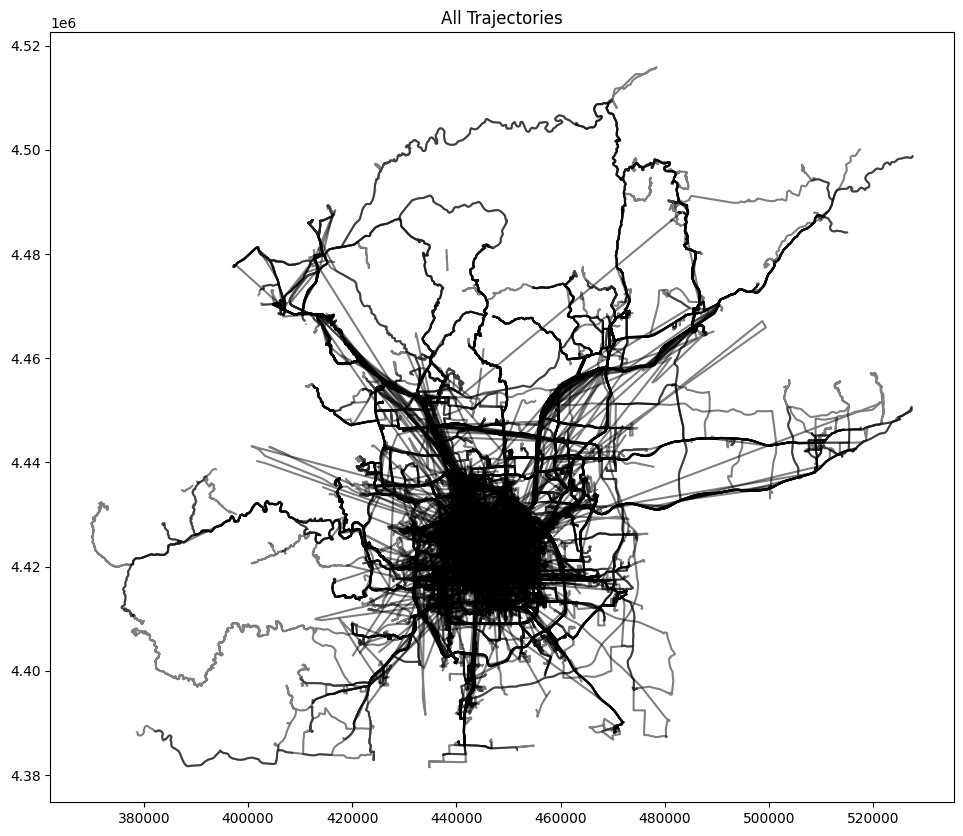

In [13]:
plot_trajectories(gdf)

In [20]:
def calculate_projected_distance(point1, point2):
    return np.sqrt((point1.x - point2.x)**2 + (point1.y - point2.y)**2)

def contains_outlier(line, threshold):
    coords = list(line.coords)
    for i in range(1, len(coords)):
        point1 = Point(coords[i-1])
        point2 = Point(coords[i])
        if calculate_projected_distance(point1, point2) > threshold:
            return True
    return False

def filter_trajectories(gdf, threshold):
    return gdf[~gdf['geometry'].apply(lambda geom: contains_outlier(geom, threshold))]

def plot_threshold_vs_trajectory_count(gdf, thresholds):
    counts = []
    for threshold in thresholds:
        filtered_gdf = filter_trajectories(gdf, threshold)
        counts.append(len(filtered_gdf))

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, counts, marker='o')
    plt.xlabel('Distance Threshold (meters)')
    plt.ylabel('Number of Trajectories')
    plt.title('Number of Trajectories vs. Distance Threshold')
    plt.grid(True)
    plt.xticks(np.arange(min(thresholds), max(thresholds) + 500, 500))
    plt.show()

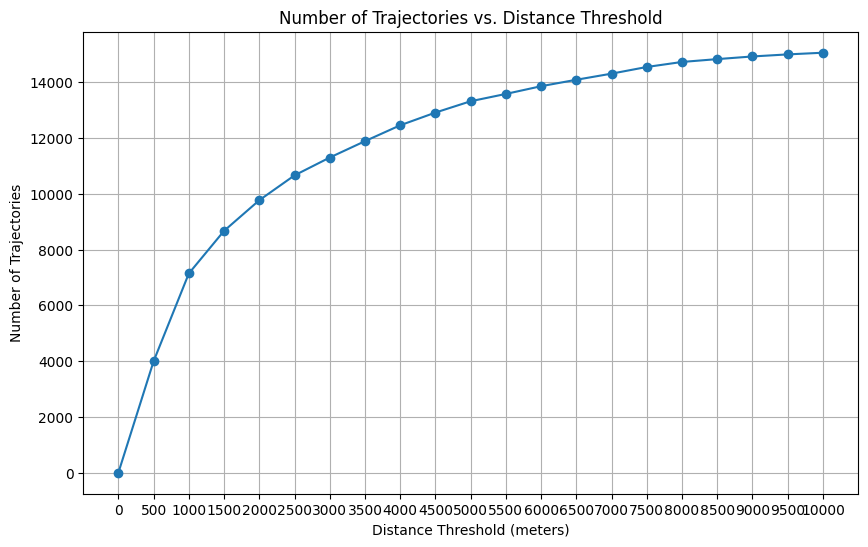

In [140]:
# Definiowanie zakresu progów do analizy
thresholds = np.arange(0, 10001, 500)

# Tworzenie wykresu
plot_threshold_vs_trajectory_count(gdf, thresholds)

In [21]:
distance_threshold = 2000

In [22]:
gdf['contains_outlier'] = gdf['geometry'].apply(lambda line: contains_outlier(line, distance_threshold))

In [23]:
clean_gdf = gdf[~gdf['contains_outlier']]

print(f"Liczba trajektorii przed czyszczeniem: {len(gdf)}")
print(f"Liczba trajektorii po czyszczeniu: {len(clean_gdf)}")

Liczba trajektorii przed czyszczeniem: 15794
Liczba trajektorii po czyszczeniu: 9767


In [24]:
outliers = gdf[gdf['contains_outlier']]

def get_trajectory_by_id(traj_col, target_id):
  for trajectory in traj_col.trajectories:
    if trajectory.id == target_id:  # Replace 'id' with the correct attribute
      return trajectory
  return None  # If no match is found

outlier1 = get_trajectory_by_id(traj_col, outliers.iloc[4, 4])
outlier2 = get_trajectory_by_id(traj_col, outliers.iloc[992, 4])#outliers.iloc[10, 4])

outlier1.hvplot(**kwargs)+outlier2.hvplot(**kwargs) 

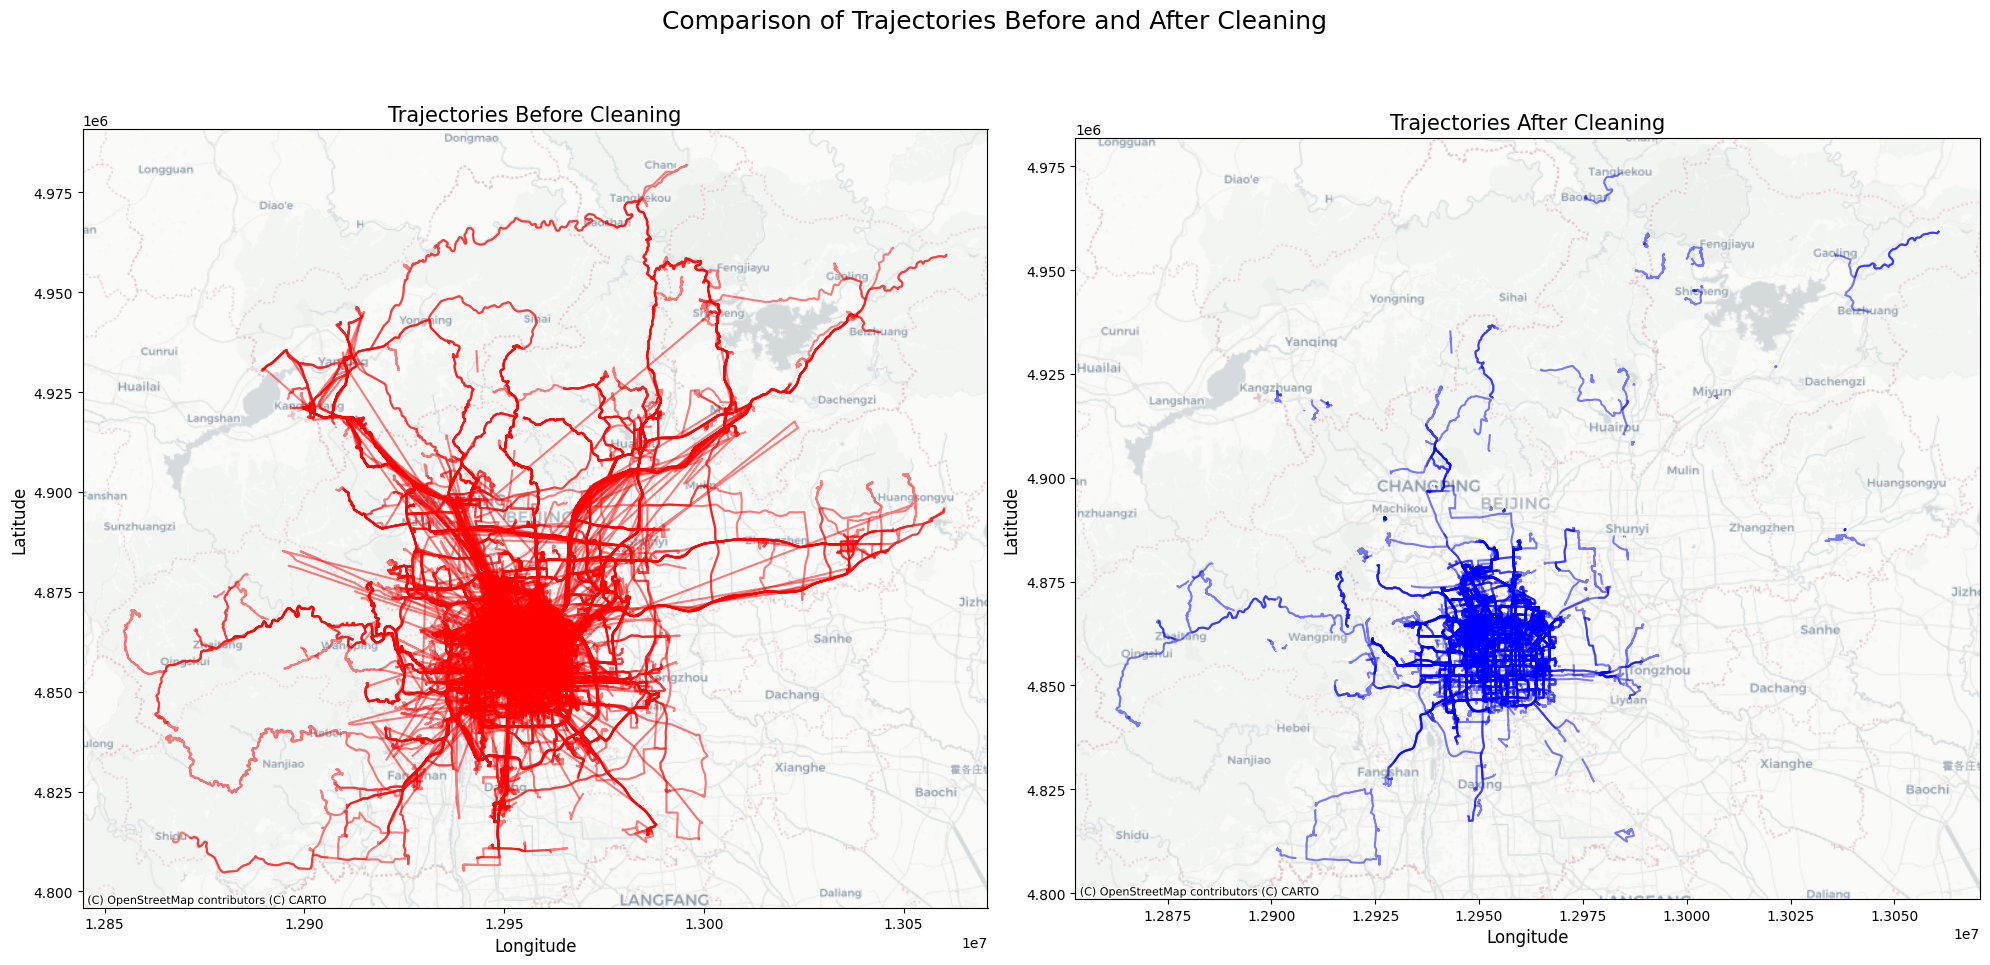

In [27]:
# Przygotowanie danych w CRS EPSG:3857 dla zgodności z contextily
gdf_mercator = gdf.to_crs(epsg=3857)
clean_gdf_mercator = clean_gdf.to_crs(epsg=3857)

# Tworzenie subplots z większymi wymiarami
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Ustawienia dla wykresu przed czyszczeniem
gdf_mercator.plot(ax=ax[0], color='red', alpha=0.5, edgecolor='k')
ctx.add_basemap(ax[0], crs=gdf_mercator.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ax[0].set_title('Trajectories Before Cleaning', fontsize=15)
ax[0].set_xlabel('Longitude', fontsize=12)
ax[0].set_ylabel('Latitude', fontsize=12)

# Ustawienia dla wykresu po czyszczeniu
clean_gdf_mercator.plot(ax=ax[1], color='blue', alpha=0.5, edgecolor='k')
ctx.add_basemap(ax[1], crs=clean_gdf_mercator.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ax[1].set_title('Trajectories After Cleaning', fontsize=15)
ax[1].set_xlabel('Longitude', fontsize=12)
ax[1].set_ylabel('Latitude', fontsize=12)

# Ustawienia ogólne
plt.suptitle('Comparison of Trajectories Before and After Cleaning', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Zapisanie wykresu do pliku PDF
plt.savefig('Trajectories_cleaning.pdf')

# Wyświetlenie wykresu
plt.show()

In [148]:
clean_gdf.to_parquet(os.path.join('output_data', f'geolife_cleaned_{distance_threshold}.parquet'))

# EDA 2

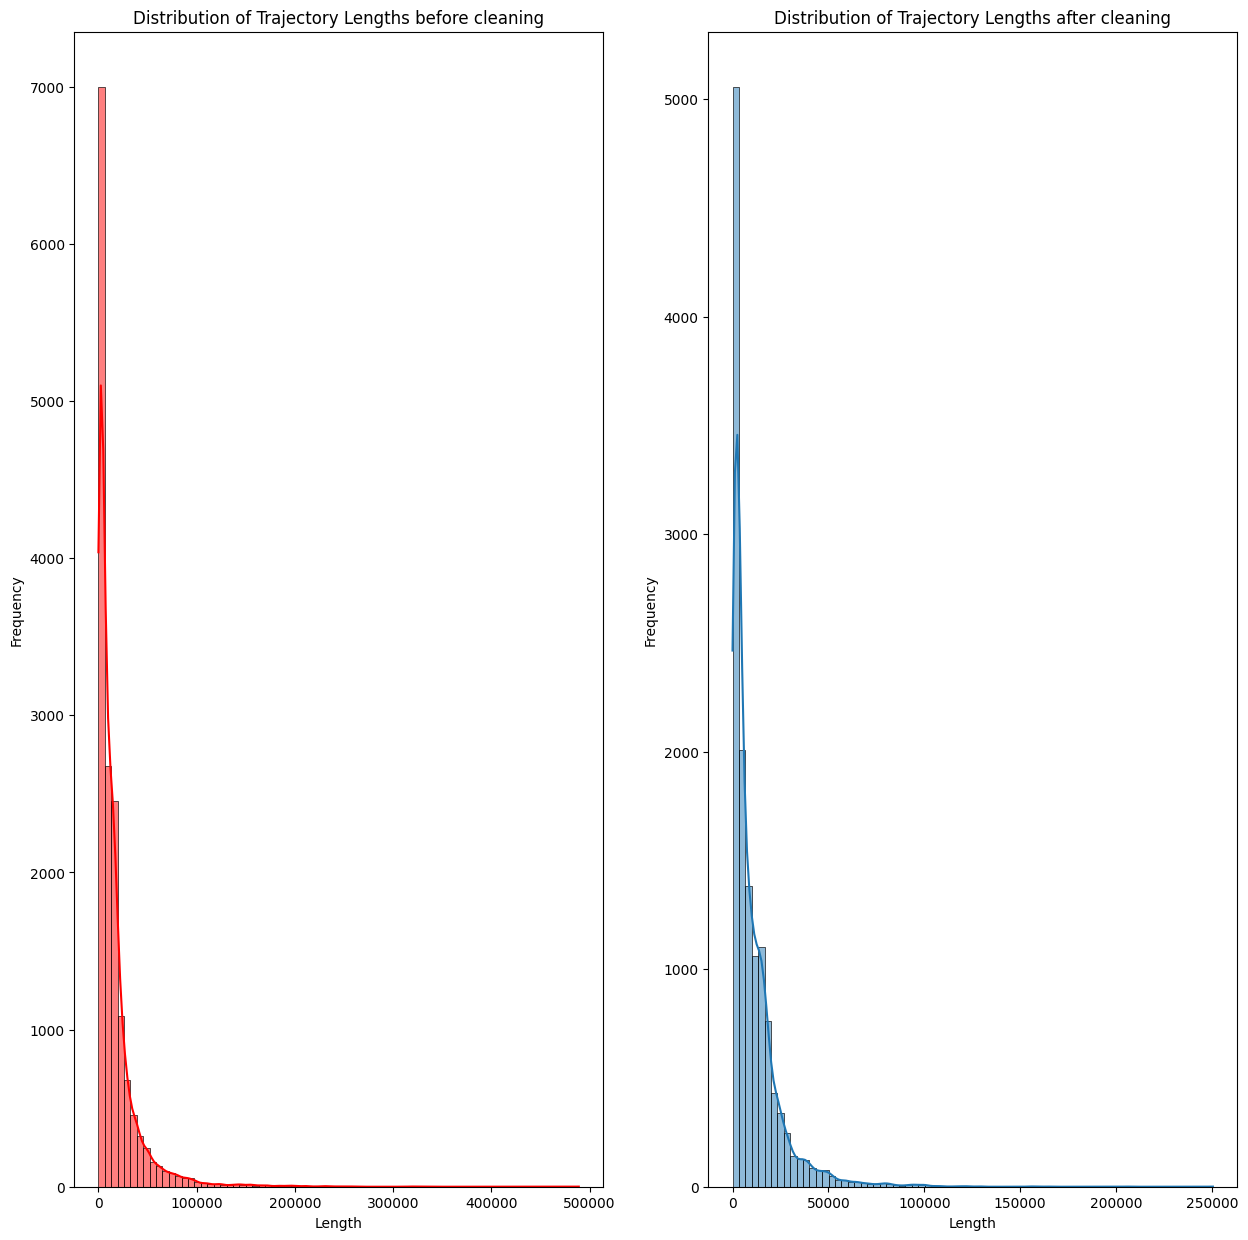

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
# hist plot clean_gdf and gdf

sns.histplot(gdf['length'], bins=75, kde=True, ax=ax[0], color= 'red')
ax[0].set_title('Distribution of Trajectory Lengths before cleaning')
ax[0].set_xlabel('Length')
ax[0].set_ylabel('Frequency')
    
sns.histplot(clean_gdf['length'], bins=75, kde=True, ax=ax[1])
ax[1].set_title('Distribution of Trajectory Lengths after cleaning')
ax[1].set_xlabel('Length')
ax[1].set_ylabel('Frequency')

plt.show()

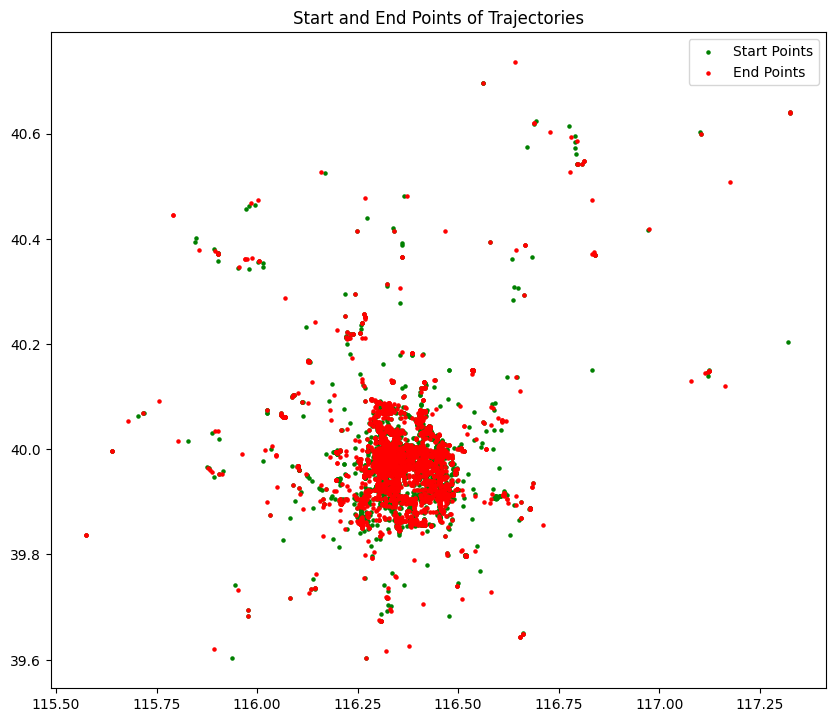

In [75]:
# Ekstrakcja punktów początkowych i końcowych
gdf['start_point'] = gdf['geometry'].apply(lambda x: x.coords[0])
gdf['end_point'] = gdf['geometry'].apply(lambda x: x.coords[-1])
start_points = gpd.GeoDataFrame(gdf, geometry=gdf['start_point'].apply(Point), crs=gdf.crs)
end_points = gpd.GeoDataFrame(gdf, geometry=gdf['end_point'].apply(Point), crs=gdf.crs)

# Wizualizacja punktów początkowych i końcowych
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
start_points.plot(ax=ax, color='green', markersize=5, label='Start Points')
end_points.plot(ax=ax, color='red', markersize=5, label='End Points')
plt.title('Start and End Points of Trajectories')
plt.legend()
plt.show()

In [20]:
# Analiza czasowa (jeśli dostępne dane czasowe)
# Zakładając, że masz kolumny 'start_time' i 'end_time' w formacie datetime
if 'start_time' in gdf.columns and 'end_time' in gdf.columns:
    gdf['start_time'] = pd.to_datetime(gdf['start_time'])
    gdf['end_time'] = pd.to_datetime(gdf['end_time'])
    gdf['duration'] = (gdf['end_time'] - gdf['start_time']).dt.total_seconds()

    # Rozkład czasowy trajektorii
    plt.figure(figsize=(12, 6))
    sns.histplot(gdf['start_time'].dt.hour, bins=24, kde=True)
    plt.title('Distribution of Trajectories by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Frequency')
    plt.show()

    # Statystyki czasu trwania trajektorii
    print(gdf['duration'].describe())

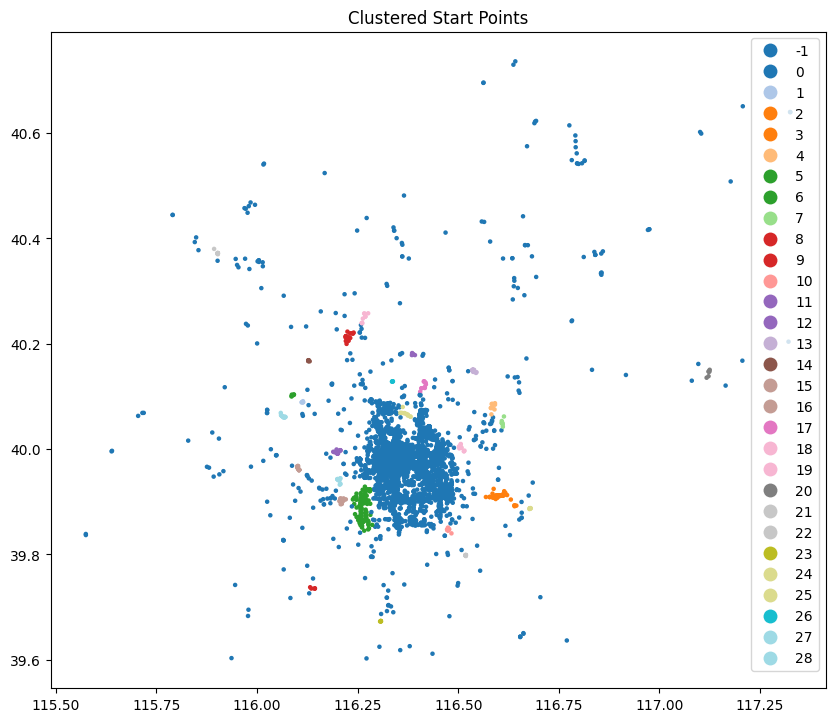

In [19]:
# Analiza przestrzenna (klasteryzacja, gorące punkty, etc.)
from sklearn.cluster import DBSCAN

coords = np.vstack((start_points.geometry.apply(lambda x: (x.x, x.y)).to_list(),
                    end_points.geometry.apply(lambda x: (x.x, x.y)).to_list()))
db = DBSCAN(eps=0.01, min_samples=10).fit(coords)  # Zmień eps w zależności od skali danych
labels = db.labels_

# Dodanie etykiet klastrów do startowych i końcowych punktów
start_points['cluster'] = labels[:len(start_points)]
end_points['cluster'] = labels[len(start_points):]

# Wizualizacja klastrów
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
start_points.plot(ax=ax, column='cluster', categorical=True, legend=True, markersize=5, cmap='tab20')
plt.title('Clustered Start Points')

# Haotic Trajectories

In [34]:
# Funkcja do obliczania średniej i mediany odległości między punktami w trajektorii
def calculate_distances_stats(line):
    coords = list(line.coords)
    distances = [
        calculate_distance(Point(coords[i-1]), Point(coords[i]))
        for i in range(1, len(coords))
    ]
    if len(distances) > 0:
        return np.mean(distances), np.median(distances)
    else:
        return None, None

# Funkcja do obliczania współczynnika zbieżności punktów trajektorii
def calculate_dispersion(line):
    coords = list(line.coords)
    if len(coords) > 1:
        centroid = LineString(coords).centroid
        dispersions = [calculate_distance(Point(coord), centroid) for coord in coords]
        return np.mean(dispersions)
    else:
        return None

In [40]:
# Obliczanie statystyk dla każdej trajektorii
gdf['mean_distance'], gdf['median_distance'] = zip(*gdf['geometry'].apply(calculate_distances_stats))
gdf['dispersion'] = gdf['geometry'].apply(calculate_dispersion)

In [41]:
# Ustal progi dla wykrywania chaotycznych trajektorii
mean_distance_threshold = 100  # Próg dla średniej odległości między punktami (np. 10 metrów)
dispersion_threshold = 20     # Próg dla rozproszenia punktów (np. 20 metrów)

# Wykrywanie chaotycznych trajektorii
gdf['is_chaotic'] = (gdf['mean_distance'] < mean_distance_threshold) & (gdf['dispersion'] < dispersion_threshold)



# Usunięcie chaotycznych trajektorii
clean_gdf = gdf[~gdf['is_chaotic']]

# Wyświetlenie wyników
print(f"Liczba trajektorii przed czyszczeniem: {len(gdf)}")
print(f"Liczba trajektorii po czyszczeniu: {len(clean_gdf)}")

Liczba trajektorii przed czyszczeniem: 15794
Liczba trajektorii po czyszczeniu: 15671


In [51]:
chaotic_trajs = gdf[gdf['is_chaotic']]

In [52]:
chaotic_trajs.head()

,geometry,date_str,speed,altitude,trajectory_id,start_point,end_point,contains_outlier,length,mean_distance,median_distance,dispersion,is_chaotic
trajectory_id,,,,,,,,,,,,,
20071208035046,"LINESTRING (116.30245 39.98653, 116.30232 39.9...","[2007-12-08, 2007-12-08, 2007-12-08, 2007-12-08]","[2.0255593872570308, 1.4726604429116488, 2.037...","[206.7, 210.0, 210.0, 206.7]",20071208035046,"(116.30244549158472, 39.98652833976475)","(116.30236572294726, 39.98611989162324)",False,0.000554,19.270401,11.084105,19.292763,True
20071229100234,"LINESTRING (116.29830 39.99040, 116.29802 39.9...","[2007-12-29, 2007-12-29, 2007-12-29]","[0.8481684373129657, 2.5478969253210653, 0.573...","[0.0, 0.0, 0.0]",20071229100234,"(116.29829883424675, 39.99039927163797)","(116.29811108452179, 39.990632622203044)",False,0.000509,24.223540,24.223540,15.098027,True
20080129083237,"LINESTRING (116.31352 39.96897, 116.31345 39.9...","[2008-01-29, 2008-01-29, 2008-01-29]","[1.3675247942173576, 1.1493367932802208, 1.511...","[0.0, 0.0, 0.0]",20080129083237,"(116.31351912010132, 39.9689712396162)","(116.3134918048068, 39.96927076656413)",False,0.000322,17.361740,17.361740,13.190801,True
20080421140530,"LINESTRING (116.33108 39.97613, 116.33109 39.9...","[2008-04-21, 2008-04-21, 2008-04-21]","[0.0, 0.0, 0.46230378476008044]","[0.0, 0.0, 0.0]",20080421140530,"(116.33108235760037, 39.976134736579354)","(116.33119716358854, 39.97609586047821)",False,0.000121,5.357538,5.357538,5.005327,True
20080510092125,"LINESTRING (116.45184 39.98835, 116.45184 39.9...","[2008-05-10, 2008-05-10, 2008-05-10, 2008-05-10]","[2.2274879939413026, 0.0290388490750776, 0.0, ...","[62.3, 75.5, 75.5, 75.5]",20080510092125,"(116.45184000191615, 39.988349988023984)","(116.45184161277359, 39.98833992016494)",False,0.000010,0.375438,0.011256,0.556123,True
